# This time we will implement a digit classifier.

In [1]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('digit-recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

digit-recognizer/test.csv
digit-recognizer/train.csv
digit-recognizer/sample_submission.csv


In [2]:
#读取csv数据，转为pandas数据
digit_recon_train_csv = pd.read_csv('digit-recognizer/train.csv')
digit_recon_test_csv = pd.read_csv('digit-recognizer/test.csv')

print('train dataset: ', digit_recon_train_csv.size)
print('test dataset: ', digit_recon_test_csv.size)

train dataset:  32970000
test dataset:  21952000


In [3]:
#将pandas数据转换为numpy
train_label = digit_recon_train_csv.label.values
train_image = digit_recon_train_csv.loc[:, digit_recon_train_csv.columns != 'label'].values / 255
test_image = digit_recon_test_csv.values / 255

print("train label shape: ", train_label.shape)
print("train image shape: ", train_image.shape)
print("test image shape: ", test_image.shape)

train label shape:  (42000,)
train image shape:  (42000, 784)
test image shape:  (28000, 784)


In [4]:
from sklearn.model_selection import train_test_split
train_image, valid_image, train_label, valid_label = train_test_split(train_image,
train_label,
test_size=0.2,
random_state=42)
print("train shape: ", train_image.shape)
print("valid shape: ", valid_image.shape)

train shape:  (33600, 784)
valid shape:  (8400, 784)


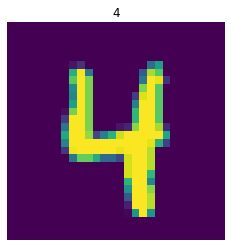

In [5]:
#可视化
import matplotlib.pyplot as plt
plt.imshow(train_image[80].reshape(28, 28))
plt.axis("off")
plt.title(str(train_label[80]))
plt.show()

In [6]:
#利用pytorch构建data_loader
import torch
import torch.nn as nn
import torch.utils.data as Data

train_image = torch.from_numpy(train_image)
train_label = torch.from_numpy(train_label).type(torch.LongTensor)

valid_image = torch.from_numpy(valid_image)
valid_label = torch.from_numpy(valid_label).type(torch.LongTensor)

train_dataset = Data.TensorDataset(train_image, train_label)
valid_dataset = Data.TensorDataset(valid_image, valid_label)

batch_size = 64
train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = Data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


In [7]:
# #利用pytorch构建模型，参考AlexNet
# import torchvision
# from torchvision import transforms
# from torchvision import models

# class MyNet(nn.Module):
#     def __init__(self):
#         super(MyNet, self).__init__()

#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(8, 16, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(16, 16, 3, 1, 1),
#             nn.ReLU(),
#             nn.Conv2d(16, 8, 3, 1, 1),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )

#         self.fc = nn.Sequential(
#             nn.Linear(8*7*7, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 10)
#         )

#     def forward(self, img):
#         x = self.conv(img)
#         o = self.fc(x.view(x.shape[0], -1))
#         return o


In [7]:
# 重新构建模型，参考ResNet
import torchvision
from torchvision import transforms
from torchvision import models
from torch.nn import functional as F

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [13]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), 
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [14]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, 
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [15]:
#构建模型，并开始训练
model = net
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
num_epoches = 7
from torch.autograd import Variable

for epoch in range(num_epoches):
    epoch_train_loss = 0.0
    epoch_train_corr = 0.0
    epoch_valid_corr = 0.0
    print("Epoch: {}/{}".format(epoch+1, num_epoches))

    for data in train_loader:
        images, labels = data
        images = Variable(images.view(64, 1, 28, 28)).float()
        labels = Variable(labels)

        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.data
        outputs = torch.max(outputs.data, 1)[1]
        epoch_train_corr += torch.sum(outputs == labels.data)

    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images = Variable(images.view(len(images), 1, 28, 28)).float()
            labels = Variable(labels)

            outputs = model(images)
            outputs = torch.max(outputs.data, 1)[1]
            epoch_valid_corr += torch.sum(outputs == labels.data)

    print("loss is: {:.4f}, train acc is: {:.4f}, test acc is: {:.4f}".format(epoch_train_loss/len(train_dataset), 100*epoch_train_corr/len(train_dataset), 100*epoch_valid_corr/len(valid_dataset)))



Epoch: 1/7
loss is: 0.0041, train acc is: 92.4494, test acc is: 96.9405
Epoch: 2/7
loss is: 0.0011, train acc is: 97.9137, test acc is: 98.0357
Epoch: 3/7
loss is: 0.0007, train acc is: 98.5298, test acc is: 98.1190
Epoch: 4/7
loss is: 0.0006, train acc is: 98.8155, test acc is: 98.7143
Epoch: 5/7
loss is: 0.0004, train acc is: 99.0893, test acc is: 98.7024
Epoch: 6/7
loss is: 0.0004, train acc is: 99.2321, test acc is: 98.6786
Epoch: 7/7
loss is: 0.0003, train acc is: 99.3601, test acc is: 98.9405


In [ ]:
plt.plot(epoch_train_corr)
plt.plot(epoch_valid_corr)
plt.title('Accuracy in Training and Validation')
plt.xlabel('epoch')
plt.ylabel('Accuracy')

In [21]:
test_results = np.zeros((test_image.shape[0], 2), dtype='int32')
for i in range(test_image.shape[0]):
    model.eval()
    one_image = Variable(torch.from_numpy(test_image[i]).view(1, 1, 28, 28).float())
    one_output = model(one_image)
    test_results[i, 0] = i + 1
    test_results[i, 1] = torch.max(one_output.data, 1)[1].numpy()

Datas = {'ImageId': test_results[:, 0], 'Label': test_results[:, 1]}
DataFrame = pd.DataFrame(Datas)
DataFrame.to_csv('submission.csv', index=False, sep=',')